In [1]:
## PyTorch
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import learn2learn as l2l

from einops import rearrange

from torch.utils.data import DataLoader
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels

from protonet_classic import ProtoNet
from protonet_custom import CustProtoNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

/gpfs/u/home/PCPB/PCPBphmb/scratch/AI-CONDA/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def GetDataLoaders(train_dataset,
                   train_shot, train_way, train_query,
                   valid_dataset,
                   valid_shot, valid_way, valid_query,
                   test_dataset, 
                   test_shot, test_way, test_query,
                  ):
    
    valid_num_tasks, test_num_tasks = 600, 2000
    
    train_dataset = l2l.data.MetaDataset(train_dataset)
    
    train_transforms = [
        NWays(train_dataset, train_way),
        KShots(train_dataset, train_query + train_shot),
        LoadData(train_dataset),
        RemapLabels(train_dataset),
    ]
    
    train_tasks = l2l.data.TaskDataset(train_dataset, 
                                       task_transforms = train_transforms)
    
    train_loader = DataLoader(train_tasks, pin_memory=True, shuffle=True)

    valid_dataset = l2l.data.MetaDataset(valid_dataset)
    
    valid_transforms = [
        NWays(valid_dataset, valid_way),
        KShots(valid_dataset, valid_query + valid_shot),
        LoadData(valid_dataset),
        RemapLabels(valid_dataset),
    ]
    
    valid_tasks = l2l.data.TaskDataset(valid_dataset,
                                       task_transforms = valid_transforms,
                                       num_tasks = valid_num_tasks)
    valid_loader = DataLoader(valid_tasks, pin_memory=True, shuffle=True)

    test_dataset = l2l.data.MetaDataset(test_dataset)
    
    test_transforms = [
        NWays(test_dataset, test_way),
        KShots(test_dataset, test_query + test_shot),
        LoadData(test_dataset),
        RemapLabels(test_dataset),
    ]
    
    test_tasks = l2l.data.TaskDataset(test_dataset,
                                      task_transforms=test_transforms,
                                      num_tasks = test_num_tasks)
    
    test_loader = DataLoader(test_tasks, pin_memory=True, shuffle=True)
    
    return train_loader, valid_loader, test_loader

# Accuracy and Distance Metric

In [3]:
def accuracy(predictions, targets):
    predictions = torch.max(predictions, -1)[-1]
    return (predictions == targets).sum().float().item() / targets.size(0)

In [4]:
def pairwise_distance_logits(a, b):
    n = a.shape[0]
    m = b.shape[0]
    
    logits = -(((a.unsqueeze(1).expand(n, m, -1) - 
                b.unsqueeze(0).expand(n, m, -1))**2).sum(dim=2))
              
    return logits

# Loss Functions
## Classic

In [5]:
def ProtoNetLoss(model, query, support, labels, ways, shots):
    # support prototypes
    cs = model.fit(support, ways, shots)
    
    # euclidean distance between embedded query and prototype
    dist = pairwise_distance_logits(query, cs)
    
    yhat = torch.log_softmax(dist, -1)
    
    return F.nll_loss(yhat, labels), accuracy(yhat, labels)

# New

In [6]:
def CustProtoNetLoss(model, query, support, labels, ways, shots, reg_val = 0.01):
    # query prototypes
    cq = model.fit(query, ways, shots)
    
    # support prototypes
    cs = model.fit(support, ways, shots)
    
    # euc-distance between embedded query and supp prototype
    dist1 = pairwise_distance_logits(query, cs)

    cq = cq.reshape(-1, cs.size(0), cs.size(1))

    # euc-distance between query proto and supp proto
    dist2 = -((cq - cs).pow(2).sum(-1))
    dist2 = dist2.repeat(labels.size(0) // dist2.size(0), 1)
    
    yhat = torch.log_softmax(dist1, -1)
    chat = torch.log_softmax(dist2, -1)
    
    # we want to maximize the two probabilities
    loss = F.nll_loss(yhat, labels) + reg_val * F.nll_loss(chat, labels)
    
    return loss, accuracy(yhat, labels)

# Adaptation (Train) Function

In [7]:
def fast_adapt(model, batch, ways, shots, query_num, loss):
    data, labels = batch
    
    data = data.to(device)
    labels = labels.to(device)
    
    n_items = shots * ways

    # Sort data samples by labels
    sort = torch.sort(labels)
    
    data = data.squeeze(0)[sort.indices].squeeze(0)
    
    labels = labels.squeeze(0)[sort.indices].squeeze(0)

    # Compute support and query embeddings
    embeddings = model(data)
    support_indices = np.zeros(data.size(0), dtype=bool)
    
    selection = np.arange(ways) * (shots + query_num)
    
    for offset in range(shots):
        support_indices[selection + offset] = True
        
    query_indices = torch.from_numpy(~support_indices)
    support_indices = torch.from_numpy(support_indices)
    
    # separate query and support
    query = embeddings[query_indices]
    support = embeddings[support_indices]   
    labels = labels[query_indices].long()   
 
    return loss(model, query, support, labels, ways, shots)

# Evaluation and Training Loop

In [8]:
def eval_proto(model, ProtoLoss, valid_loader, 
               valid_way, valid_shot, valid_query, corrupt_rate = 0.0):
    from random import random
    
    model.eval()
    Loss, Acc = 0.0, 0.0
    corrupt_image_p = -1.0
    
    with torch.no_grad():
        for i, batch in enumerate(valid_loader):
            if corrupt_rate > 0.0:
                corrupt_image_p = random()
            
            if corrupt_image_p <= corrupt_rate and corrupt_image_p > 0.0:
                batch[0] += torch.randn(batch[0].shape) * (0.5 ** 0.5)
            
            loss, acc = fast_adapt( model,
                                    batch,
                                    valid_way,
                                    valid_shot,
                                    valid_query,
                                    ProtoLoss
                                  )

            Acc += acc
            Loss += loss.item()
    
    Acc /= len(valid_loader)
    Loss /= len(valid_loader)
    
    return Loss, Acc

In [9]:
def train_proto(model, optimizer, lr_scheduler, ProtoLoss,
                train_loader, 
                train_way, train_shot, train_query,
                
                valid_loader, 
                valid_way, valid_shot, valid_query,
                epochs = 10, episodes = 100, corrupt_rate = 0.0, save_path = None):
    
    assert(epochs > 0 and episodes > 0)
    
    from random import random
    
    model.train()
    
    train_ahist, valid_ahist = [], []
    train_lhist, valid_lhist = [], []
    
    for epoch in range(1, epochs + 1):
        Loss, Acc = 0.0, 0.0
        
        corrupt_image_p = -1.0
        
        for i in range(episodes):
            
            batch = next(iter(train_loader))
            
            """ Corrupt some images based on some probability """
            if corrupt_rate > 0.0:
                corrupt_image_p = random()
            
            # Add Gaussian Noise with Variance of 0.7
            if corrupt_image_p <= corrupt_rate and corrupt_image_p > 0.0:
                batch[0] += torch.randn(batch[0].shape) * (0.5 ** 0.5)
            
            loss, acc = fast_adapt( model,
                                    batch,
                                    train_way,
                                    train_shot,
                                    train_query,
                                    ProtoLoss,
                                  )

            Acc += acc
            Loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        lr_scheduler.step()
        
        Acc /= episodes
        Loss /= episodes
        
        train_ahist.append(Acc)
        train_lhist.append(Loss)
        print("Epoch: {0}\tLoss: {1:.8f}\tAcc: {2:.5f}".format(epoch, Loss, Acc))
        
        # Perform Validation
        valLoss, valAcc = eval_proto(model, ProtoLoss, valid_loader, valid_way, valid_shot, valid_query, corrupt_rate)
        print("Val--- Loss: {0:.8f}\tAcc: {1:.5f}".format(valLoss, valAcc))
        
        valid_ahist.append(valAcc)
        valid_lhist.append(valLoss)
        
        # save per epoch
        if (save_path != None and type(save_path) == str):
            checkpoint = {'Train-AHist' : train_ahist,
                          'Train-LHist' : train_lhist,
                          'Val-AHist' : valid_ahist,
                          'Val-LHist' : valid_lhist,
                          'state_dict': model.state_dict(),
                          'optimizer': optimizer.state_dict(),
                         }
            
            torch.save(checkpoint, save_path)
        
    
    return model, optimizer, (train_ahist, valid_ahist, train_lhist, valid_lhist)

# Model Reload Function

In [10]:
def reload(model, optimizer, path):
    import os 
    
    if (os.path.isfile(path)):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    
    return model, optimizer,

# Load MiniImagenet

In [11]:
train_dataset = l2l.vision.datasets.MiniImagenet(
    root="../data/", mode='train', download=True)
    
valid_dataset = l2l.vision.datasets.MiniImagenet(
    root="../data/", mode='validation', download=True)

test_dataset = l2l.vision.datasets.MiniImagenet(
    root="../data/", mode='test', download=True)

## According to Proto Paper (Snell et al. pg. 6) 
## Train ProtoNet with 20-way for 5 shot
## Validate and Test with 5 way 5 shot

In [12]:
train_way, valid_way, test_way = 20, 5, 5
    
train_shot, valid_shot, test_shot = 5, 5, 5

train_query, valid_query, test_query = 15, 15, 15

In [13]:
train_loader, valid_loader, test_loader = GetDataLoaders(train_dataset, train_shot, train_way, train_query,
                                                         valid_dataset, valid_shot, valid_way, valid_query,
                                                         test_dataset, test_shot, test_way, test_query
                                                        )

# Train the Original Model with Original Loss Function

In [14]:
classic_model = ProtoNet(in_channels = 3, out_dim = 64, hid_dim = 128)
classic_model = classic_model.to(device)
classic_optimizer = optim.Adam(classic_model.parameters(), lr = 1e-3)

classic_model, classic_optimizer = reload(classic_model, 
                                          classic_optimizer, "classic_protonet_l1.pth")

classic_lr_scheduler = optim.lr_scheduler.StepLR(classic_optimizer, step_size = 10, gamma=0.5)

classic_model, classic_optimizer, hist1 = train_proto(classic_model, classic_optimizer, 
                                                       classic_lr_scheduler, ProtoNetLoss,
                                                       train_loader, 
                                                       train_way, train_shot, train_query,
                                                       valid_loader, 
                                                       valid_way, valid_shot, valid_query,
                                                       epochs = 10, episodes = 200, corrupt_rate = 0.5, save_path = "classic_protonet_l1.pth")

Epoch: 1	Loss: 11.37568003	Acc: 0.14983
Val--- Loss: 1.48392528	Acc: 0.36149


/gpfs/u/home/PCPB/PCPBphmb/scratch/AI-CONDA/lib/python3.9/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Epoch: 2	Loss: 2.65778637	Acc: 0.20038
Val--- Loss: 1.35805348	Acc: 0.43673
Epoch: 3	Loss: 2.51147727	Acc: 0.24550
Val--- Loss: 1.32440432	Acc: 0.45736
Epoch: 4	Loss: 2.42348406	Acc: 0.27183
Val--- Loss: 1.29873669	Acc: 0.46904
Epoch: 5	Loss: 2.36066620	Acc: 0.28778
Val--- Loss: 1.26994116	Acc: 0.48551
Epoch: 6	Loss: 2.30058993	Acc: 0.30232
Val--- Loss: 1.23529800	Acc: 0.49996
Epoch: 7	Loss: 2.25757733	Acc: 0.31563
Val--- Loss: 1.23860557	Acc: 0.50431
Epoch: 8	Loss: 2.23257493	Acc: 0.32295
Val--- Loss: 1.15967400	Acc: 0.53580
Epoch: 9	Loss: 2.16163034	Acc: 0.34025
Val--- Loss: 1.18716302	Acc: 0.52709
Epoch: 10	Loss: 2.14952027	Acc: 0.34753
Val--- Loss: 1.16017019	Acc: 0.53633


# Train Custom Model With Custom Loss Function

In [14]:
cust_model = CustProtoNet(in_channels = 3, out_dim = 64, hid_dim = 128)

cust_model = cust_model.to(device)

cust_optimizer = optim.Adam(cust_model.parameters(), lr = 1e-3)

cust_model, cust_optimizer = reload(cust_model, cust_optimizer, "custom_protonet_l2.pth")

cust_lr_scheduler = optim.lr_scheduler.StepLR(cust_optimizer, step_size = 20, gamma=0.5)

cust_model, cust_optimizer, hist4 = train_proto(cust_model, cust_optimizer, cust_lr_scheduler, CustProtoNetLoss,
                                               train_loader, 
                                               train_way, train_shot, train_query,
                                               valid_loader, 
                                               valid_way, valid_shot, valid_query,
                                               epochs = 40, episodes = 200, corrupt_rate = 0.5, save_path = "custom_protonet_l2.pth")

Epoch: 1	Loss: 17.40981426	Acc: 0.15695
Val--- Loss: 1.55047221	Acc: 0.37140


/gpfs/u/home/PCPB/PCPBphmb/scratch/AI-CONDA/lib/python3.9/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Epoch: 2	Loss: 2.65489993	Acc: 0.21452
Val--- Loss: 1.38754596	Acc: 0.42829
Epoch: 3	Loss: 2.53900344	Acc: 0.24527
Val--- Loss: 1.31192861	Acc: 0.46918
Epoch: 4	Loss: 2.46412005	Acc: 0.26637
Val--- Loss: 1.29827711	Acc: 0.47538
Epoch: 5	Loss: 2.37937688	Acc: 0.29038
Val--- Loss: 1.27464366	Acc: 0.49004
Epoch: 6	Loss: 2.34865676	Acc: 0.30012
Val--- Loss: 1.29605338	Acc: 0.48036
Epoch: 7	Loss: 2.31109235	Acc: 0.31037
Val--- Loss: 1.21810691	Acc: 0.51664
Epoch: 8	Loss: 2.26522995	Acc: 0.32333
Val--- Loss: 1.23033961	Acc: 0.50907
Epoch: 9	Loss: 2.21549895	Acc: 0.33665
Val--- Loss: 1.17369334	Acc: 0.53467
Epoch: 10	Loss: 2.17187415	Acc: 0.34675
Val--- Loss: 1.19363749	Acc: 0.52364
Epoch: 11	Loss: 2.14694352	Acc: 0.35627
Val--- Loss: 1.15598761	Acc: 0.54284
Epoch: 12	Loss: 2.07537771	Acc: 0.37463
Val--- Loss: 1.15604753	Acc: 0.54418
Epoch: 13	Loss: 2.07492784	Acc: 0.37377
Val--- Loss: 1.15887246	Acc: 0.54524
Epoch: 14	Loss: 2.07168759	Acc: 0.37560
Val--- Loss: 1.14307510	Acc: 0.55122
Epoch: 

# Test Models with 0.5 (50%) corruption rate
### Each test loader has 2000 episodes (or 2000 batches) in GetDataLoaders()

In [32]:
train_way, valid_way, test_way = 20, 5, 5
    
train_shot, valid_shot, test_shot = 5, 5, 5

train_query, valid_query, test_query = 15, 15, 15

## Test the Classic Model trained w/ Classic Loss (Model 1)

In [18]:
clf1 = ProtoNet(in_channels = 3, out_dim = 64, hid_dim = 128)
clf1 = clf1.to(device)

clf1_opt = optim.Adam(clf1.parameters(), lr = 1e-3)
clf1, _ = reload(clf1, clf1_opt, "classic_protonet_l1.pth")

clf1_loss, clf1_acc = [], []

for _ in range(5):
    _, _, test_loader = GetDataLoaders(train_dataset, train_shot, train_way, train_query,
                                        valid_dataset, valid_shot, valid_way, valid_query,
                                        test_dataset, test_shot, test_way, test_query
                                        )
        
    loss, acc = eval_proto(clf1, ProtoNetLoss, test_loader, 
                           test_way, test_shot, test_query, 
                           corrupt_rate = 0.5)
    clf1_acc.append(acc)
    clf1_loss.append(loss)
    
    print("Loss: {0:.8f} \t Acc: {1:.5f}".format(loss, acc))
    
print("\nAvg-Loss: {0:.8f} \t Avg-Acc: {1:.5f} \t Std-Acc: {2:.5f}".format(np.array(clf1_loss).mean(), 
                                                                         np.array(clf1_acc).mean(), 
                                                                         np.array(clf1_acc).std()))

Loss: 1.10283968 	 Acc: 0.56025
Loss: 1.09969471 	 Acc: 0.56067
Loss: 1.09958767 	 Acc: 0.56335
Loss: 1.10234089 	 Acc: 0.56153
Loss: 1.11085636 	 Acc: 0.55897

Avg-Loss: 1.10306386 	 Avg-Acc: 0.56095 	 Std-Acc: 0.00146


## Test the Custom Model trained w/ Custom Loss (Model 2)

In [15]:
clf2 = CustProtoNet(in_channels = 3, out_dim = 64, hid_dim = 128)
clf2 = clf2.to(device)

clf2_opt = optim.Adam(clf2.parameters(), lr = 1e-3)
clf2, _ = reload(clf2, clf2_opt, "custom_protonet_l2.pth")

clf2_loss, clf2_acc = [], []

for _ in range(5):
    _, _, test_loader = GetDataLoaders(train_dataset, train_shot, train_way, train_query,
                                        valid_dataset, valid_shot, valid_way, valid_query,
                                        test_dataset, test_shot, test_way, test_query
                                        )
        
    loss, acc = eval_proto(clf2, CustProtoNetLoss, test_loader, 
                           test_way, test_shot, test_query, 
                           corrupt_rate = 0.5)
    clf2_acc.append(acc)
    clf2_loss.append(loss)
    
    print("Loss: {0:.8f} \t Acc: {1:.5f}".format(loss, acc))
    
print("\nAvg-Loss: {0:.8f} \t Avg-Acc: {1:.5f} \t Std-Acc: {2:.5f}".format(np.array(clf2_loss).mean(), 
                                                                         np.array(clf2_acc).mean(), 
                                                                         np.array(clf2_acc).std()))

Loss: 0.97531233 	 Acc: 0.63369
Loss: 0.96519444 	 Acc: 0.63769
Loss: 0.96284826 	 Acc: 0.63888
Loss: 0.96959615 	 Acc: 0.63495
Loss: 0.97092916 	 Acc: 0.63469

Avg-Loss: 0.96877607 	 Avg-Acc: 0.63598 	 Std-Acc: 0.00196


In [16]:
clf2 = CustProtoNet(in_channels = 3, out_dim = 64, hid_dim = 128)
clf2 = clf2.to(device)

clf2_opt = optim.Adam(clf2.parameters(), lr = 1e-3)
clf2, _ = reload(clf2, clf2_opt, "custom_protonet_l2.pth")

clf2_loss, clf2_acc = [], []

for _ in range(5):
    _, _, test_loader = GetDataLoaders(train_dataset, train_shot, train_way, train_query,
                                        valid_dataset, valid_shot, valid_way, valid_query,
                                        test_dataset, test_shot, test_way, test_query
                                        )
        
    loss, acc = eval_proto(clf2, CustProtoNetLoss, test_loader, 
                           test_way, test_shot, test_query, 
                           corrupt_rate = 0.3)
    clf2_acc.append(acc)
    clf2_loss.append(loss)
    
    print("Loss: {0:.8f} \t Acc: {1:.5f}".format(loss, acc))
    
print("\nAvg-Loss: {0:.8f} \t Avg-Acc: {1:.5f} \t Std-Acc: {2:.5f}".format(np.array(clf2_loss).mean(), 
                                                                         np.array(clf2_acc).mean(), 
                                                                         np.array(clf2_acc).std()))

Loss: 0.97831556 	 Acc: 0.63227
Loss: 0.96863284 	 Acc: 0.63495
Loss: 0.97064643 	 Acc: 0.63458
Loss: 0.96682899 	 Acc: 0.63661
Loss: 0.96195190 	 Acc: 0.63831

Avg-Loss: 0.96927514 	 Avg-Acc: 0.63534 	 Std-Acc: 0.00203


In [17]:
clf2 = CustProtoNet(in_channels = 3, out_dim = 64, hid_dim = 128)
clf2 = clf2.to(device)

clf2_opt = optim.Adam(clf2.parameters(), lr = 1e-3)
clf2, _ = reload(clf2, clf2_opt, "custom_protonet_l2.pth")

clf2_loss, clf2_acc = [], []

for _ in range(5):
    _, _, test_loader = GetDataLoaders(train_dataset, train_shot, train_way, train_query,
                                        valid_dataset, valid_shot, valid_way, valid_query,
                                        test_dataset, test_shot, test_way, test_query
                                        )
        
    loss, acc = eval_proto(clf2, CustProtoNetLoss, test_loader, 
                           test_way, test_shot, test_query, 
                           corrupt_rate = 0.1)
    clf2_acc.append(acc)
    clf2_loss.append(loss)
    
    print("Loss: {0:.8f} \t Acc: {1:.5f}".format(loss, acc))
    
print("\nAvg-Loss: {0:.8f} \t Avg-Acc: {1:.5f} \t Std-Acc: {2:.5f}".format(np.array(clf2_loss).mean(), 
                                                                         np.array(clf2_acc).mean(), 
                                                                         np.array(clf2_acc).std()))

Loss: 0.96007232 	 Acc: 0.64057
Loss: 0.96422618 	 Acc: 0.64031
Loss: 0.96674590 	 Acc: 0.63627
Loss: 0.98211414 	 Acc: 0.63273
Loss: 0.96471389 	 Acc: 0.63880

Avg-Loss: 0.96757449 	 Avg-Acc: 0.63773 	 Std-Acc: 0.00293


# Visualize Prototypes of 5-way 100-shot 

In [14]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

clf2 = CustProtoNet(in_channels = 3, out_dim = 64, hid_dim = 128)
clf2 = clf2.to(device)

clf2_opt = optim.Adam(clf2.parameters(), lr = 1e-3)
clf2, _ = reload(clf2, clf2_opt, "custom_protonet_l2.pth")

In [137]:
train_way, valid_way, test_way = 20, 5, 5
    
train_shot, valid_shot, test_shot = 5, 5, 100

train_query, valid_query, test_query = 15, 15, 1

_, valid_loader, test_loader = GetDataLoaders(train_dataset, train_shot, train_way, train_query,
                                    valid_dataset, valid_shot, valid_way, valid_query,
                                    test_dataset, test_shot, test_way, test_query
                                    )

X, y = next(iter(test_loader))

X, y = X.squeeze(0), y.squeeze(0)

X = X.to(device)
y = y.to(device)

sort = torch.sort(y)
    
X = X[sort.indices]
    
y = y[sort.indices]

In [138]:
fq = clf2(X)
cq = clf2.fit(fq, test_way, test_shot)

cq = cq.cpu().detach().numpy()
fq = fq.cpu().detach().numpy()

fq_embedded = TSNE(n_components=2, perplexity=test_way, learning_rate=50,
                      init='random').fit_transform(fq)

cq_embedded = TSNE(n_components=2, perplexity=test_way, learning_rate=50,
                      init='random').fit_transform(cq)

/gpfs/u/home/PCPB/PCPBphmb/scratch/AI-CONDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/gpfs/u/home/PCPB/PCPBphmb/scratch/AI-CONDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


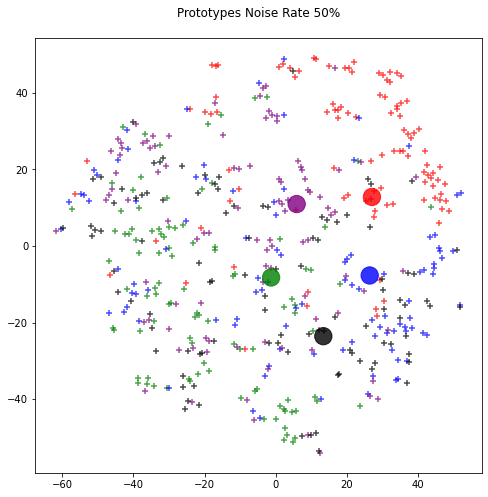

In [157]:
labels = [i for i in range(test_way)]
colors = ['red','green','blue','purple', 'black']

plt.figure(figsize=(8, 8))
plt.title("Prototypes Noise Rate 50%\n")

plt.scatter(fq_embedded[:, 0], fq_embedded[:, 1], c=y.cpu().detach().numpy(), cmap=ListedColormap(colors), alpha=0.7, marker='+')
plt.scatter(cq_embedded[:, 0], cq_embedded[:, 1], c=labels, cmap=ListedColormap(colors), s = 300, alpha = 0.8)

plt.show()

# Prototypes of 3-way 100-shot 

In [91]:
train_way, valid_way, test_way = 20, 5, 3
    
train_shot, valid_shot, test_shot = 5, 5, 100

train_query, valid_query, test_query = 15, 15, 1

_, valid_loader, test_loader = GetDataLoaders(train_dataset, train_shot, train_way, train_query,
                                    valid_dataset, valid_shot, valid_way, valid_query,
                                    test_dataset, test_shot, test_way, test_query
                                    )

X, y = next(iter(test_loader))

X, y = X.squeeze(0), y.squeeze(0)

sort = torch.sort(y)
    
X = X[sort.indices]
    
y = y[sort.indices]

X = X.to(device)
y = y.to(device)

In [92]:
fq = clf2(X)
cq = clf2.fit(fq, test_way, test_shot)

cq = cq.cpu().detach().numpy()
fq = fq.cpu().detach().numpy()

fq_embedded = TSNE(n_components=2, perplexity=test_shot, learning_rate='auto',
                      init='pca').fit_transform(fq)

cq_embedded = TSNE(n_components=2, perplexity=test_way, learning_rate='auto',
                      init='pca').fit_transform(cq)

/gpfs/u/home/PCPB/PCPBphmb/scratch/AI-CONDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


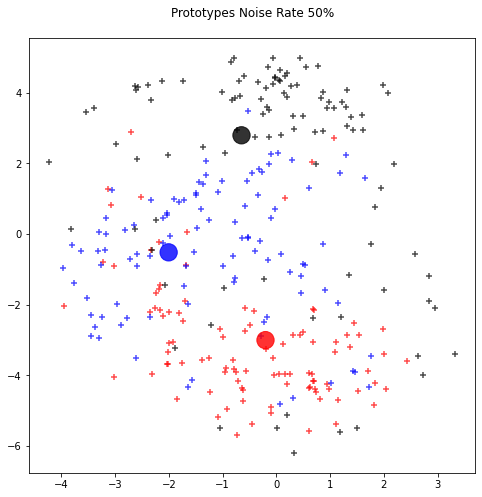

In [170]:
labels = [i for i in range(test_way)]
colors = ['red','green','blue','purple', 'black']

plt.figure(figsize=(8, 8))
plt.title("Prototypes Noise Rate 50%\n")

plt.scatter(fq_embedded[:, 0], fq_embedded[:, 1], c=y.cpu().detach().numpy(), cmap=ListedColormap(colors), alpha=0.7, marker='+')
plt.scatter(cq_embedded[:, 0], cq_embedded[:, 1], c=labels, cmap=ListedColormap(colors), s = 300, alpha = 0.8)

plt.show()

# Conclusion and Further Considerations

The work, done by Zhu et al., introduces a robust approach for computing prototypes in face of contaminated data. Through the experimental data, it is found that the method performs well, which support the data shown in the work. Meanwhile, the newly introduced loss function is also shown to perform well in constructing a robust and better performing ProtoNet in contrasts to the classic model and the one presented in Zhu et al. However, one thing to consider, based on observations, is that the distance metric utilized in both works (Snell et al. and Zhu et al.) is the squared euclidean distance, which is inadequate in high dimensionality; another metric should be considered instead. Additionally, without considering noise or contamination, we can further improve the embedding function and prototypes via taking into account spectral information. 

With such considerations, there are many directions to continue exploring the improvements of ProtoNet under contamination of data.